## Data Loading

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kevinvagan/fraud-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chefj\.cache\kagglehub\datasets\kevinvagan\fraud-detection-dataset\versions\1


In [16]:
import pandas as pd
df = pd.read_csv(r"C:\Users\chefj\.cache\kagglehub\datasets\kevinvagan\fraud-detection-dataset\versions\1\Dataset\merged_dataset.csv")
print("🧠 Shape:", df.shape)
print(df.dtypes)
print("\n❓ Missing values:\n", df.isnull().sum())
print("\n🕵️‍♂️ Class balance:\n", df["Is.Fraudulent"].value_counts(normalize=True))
df.head()

🧠 Shape: (300000, 14)
Transaction.Date       object
Transaction.Amount    float64
Customer.Age            int64
Is.Fraudulent           int64
Account.Age.Days        int64
Transaction.Hour        int64
source                 object
browser                object
sex                    object
Payment.Method         object
Product.Category       object
Quantity                int64
Device.Used            object
Address.Match           int64
dtype: object

❓ Missing values:
 Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Is.Fraudulent         0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
sex                   0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Address.Match         0
dtype: int64

🕵️‍♂️ Class balance:
 0    0.92799
1    0.07201
Name: Is.Fraudulent, dtype: float64


,Transaction.Date,Transaction.Amount,Customer.Age,Is.Fraudulent,Account.Age.Days,Transaction.Hour,source,browser,sex,Payment.Method,Product.Category,Quantity,Device.Used,Address.Match
0,2024-02-12 10:05:21,145.98,29,0,172,10,Ads,IE,F,credit card,home & garden,3,mobile,1
1,2024-01-25 22:24:06,677.62,40,0,250,22,Direct,FireFox,M,credit card,clothing,3,desktop,1
2,2024-03-26 20:32:44,798.63,40,0,118,20,Ads,Chrome,M,PayPal,clothing,3,mobile,1
3,2024-01-07 23:14:51,314.65,34,0,187,23,SEO,IE,M,bank transfer,toys & games,3,desktop,1
4,2024-01-19 11:01:19,119.80,11,1,5,11,Direct,Safari,M,PayPal,toys & games,3,tablet,1


In [17]:
print(pd.isna(df).sum())

Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Is.Fraudulent         0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
sex                   0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Address.Match         0
dtype: int64


## Data Processing

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Engineering Code Block ---
df['log_amount'] = np.log1p(df['Transaction.Amount'])

# Time-based features — keep Transaction.Date until these are created
df['is_night'] = df['Transaction.Hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# Mismatch flag
df['address_mismatch'] = df['Address.Match'].apply(lambda x: 1 if x == 0 else 0)

# Cross-feature
df['browser_device_combo'] = df['browser'] + "_" + df['Device.Used']

# Repetition key before one-hot encoding
df['repetition_key'] = (
    df['Address.Match'].astype(str) + "_" +
    df['Device.Used'] + "_" +
    df['Payment.Method']
)
key_counts = df['repetition_key'].value_counts()
df['repetition_count'] = df['repetition_key'].map(key_counts)
df['low_repetition_flag'] = df['repetition_count'].apply(lambda x: 1 if x <= 3 else 0)


# Group rare product categories
rare = df['Product.Category'].value_counts()[df['Product.Category'].value_counts() < 1000].index
df['Product.Category'] = df['Product.Category'].replace(rare, "Other")

# Now drop Transaction.Date and ID
df.drop(columns=[col for col in ['Transaction.ID', 'Transaction.Date'] if col in df.columns], inplace=True)

# One-hot encoding
df = pd.get_dummies(df, columns=[
    "Device.Used", "Payment.Method", "Product.Category", "browser", "browser_device_combo"
], drop_first=True)

# Save
df.to_csv(r"C:\Users\chefj\Downloads\INDENG142\processed_dataset.csv", index=False)
print("✅ Processed dataset saved.")

✅ Processed dataset saved.


In [19]:
processed_df = pd.read_csv(r"C:\Users\chefj\Downloads\INDENG142\processed_dataset.csv")
print(processed_df.columns.tolist())
processed_df.head()

['Transaction.Amount', 'Customer.Age', 'Is.Fraudulent', 'Account.Age.Days', 'Transaction.Hour', 'source', 'sex', 'Quantity', 'Address.Match', 'log_amount', 'is_night', 'address_mismatch', 'repetition_key', 'repetition_count', 'low_repetition_flag', 'Device.Used_mobile', 'Device.Used_tablet', 'Payment.Method_bank transfer', 'Payment.Method_credit card', 'Payment.Method_debit card', 'Product.Category_electronics', 'Product.Category_health & beauty', 'Product.Category_home & garden', 'Product.Category_toys & games', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'browser_device_combo_Chrome_mobile', 'browser_device_combo_Chrome_tablet', 'browser_device_combo_FireFox_desktop', 'browser_device_combo_FireFox_mobile', 'browser_device_combo_FireFox_tablet', 'browser_device_combo_IE_desktop', 'browser_device_combo_IE_mobile', 'browser_device_combo_IE_tablet', 'browser_device_combo_Opera_desktop', 'browser_device_combo_Opera_mobile', 'browser_device_combo_Opera_tablet', 'bro

,Transaction.Amount,Customer.Age,Is.Fraudulent,Account.Age.Days,Transaction.Hour,source,sex,Quantity,Address.Match,log_amount,...,browser_device_combo_FireFox_tablet,browser_device_combo_IE_desktop,browser_device_combo_IE_mobile,browser_device_combo_IE_tablet,browser_device_combo_Opera_desktop,browser_device_combo_Opera_mobile,browser_device_combo_Opera_tablet,browser_device_combo_Safari_desktop,browser_device_combo_Safari_mobile,browser_device_combo_Safari_tablet
0,145.98,29,0,172,10,Ads,F,3,1,4.990297,...,0,0,1,0,0,0,0,0,0,0
1,677.62,40,0,250,22,Direct,M,3,1,6.520061,...,0,0,0,0,0,0,0,0,0,0
2,798.63,40,0,118,20,Ads,M,3,1,6.684149,...,0,0,0,0,0,0,0,0,0,0
3,314.65,34,0,187,23,SEO,M,3,1,5.754634,...,0,1,0,0,0,0,0,0,0,0
4,119.80,11,1,5,11,Direct,M,3,1,4.794136,...,0,0,0,0,0,0,0,0,0,1


## Exploratory Data Analysis

In [20]:
##fraud rate for reference

def fraud_rate_by(col):
    if col in df.columns:
        print(f"\n📊 Fraud Rate by {col}:")
        print(df.groupby(col)["Is.Fraudulent"].mean().sort_values(ascending=False))

for col in ['Device.Used', 'Payment.Method', 'Address.Match', 'Product.Category', 'source', 'browser', 'sex', 'browser_device_combo']:
    fraud_rate_by(col)


📊 Fraud Rate by Address.Match:
Address.Match
0    0.072422
1    0.071964
Name: Is.Fraudulent, dtype: float64

📊 Fraud Rate by source:
source
Direct    0.078141
Ads       0.071141
SEO       0.069773
Name: Is.Fraudulent, dtype: float64

📊 Fraud Rate by sex:
sex
M    0.075060
F    0.068407
Name: Is.Fraudulent, dtype: float64


note that these rates are more indicative of low fraud rate throughout the whole dataset (class imbalance), rather than feature importance

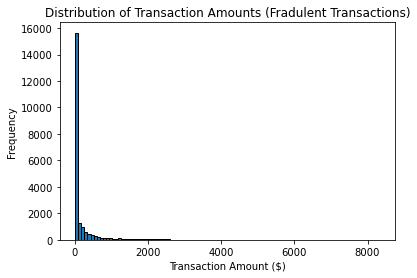

Mean Transaction Amount: 215.4966254686851
Median Transaction Amount: 47.0


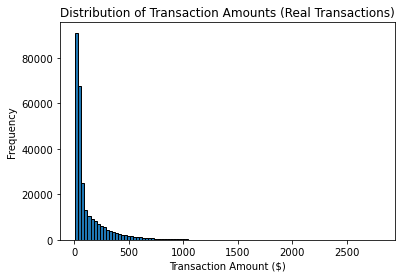

Mean Transaction Amount: 125.69319471833468
Median Transaction Amount: 54.0


In [21]:
fradulent_data = df[df['Is.Fraudulent'] == 1]
real_data = df[df['Is.Fraudulent'] == 0]

plt.hist(fradulent_data['Transaction.Amount'], bins=100, edgecolor='black')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts (Fradulent Transactions)')
plt.show()
print(f'Mean Transaction Amount: {fradulent_data["Transaction.Amount"].mean()}')
print(f'Median Transaction Amount: {fradulent_data["Transaction.Amount"].median()}')

plt.hist(real_data['Transaction.Amount'], bins=100, edgecolor='black')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts (Real Transactions)')
plt.show()
print(f'Mean Transaction Amount: {real_data["Transaction.Amount"].mean()}')
print(f'Median Transaction Amount: {real_data["Transaction.Amount"].median()}')

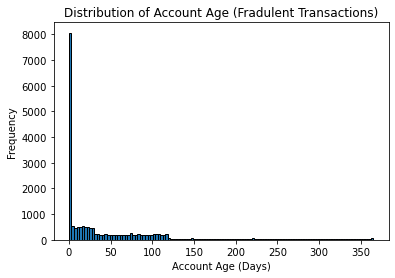

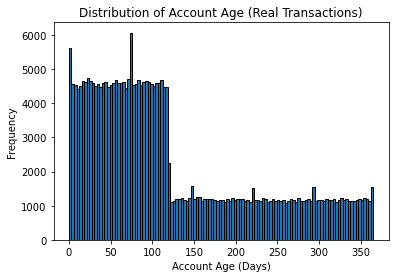

In [22]:
plt.hist(fradulent_data['Account.Age.Days'], bins=120, edgecolor='black')
plt.xlabel('Account Age (Days)')
plt.ylabel('Frequency')
plt.title('Distribution of Account Age (Fradulent Transactions)')
plt.show()

plt.hist(real_data['Account.Age.Days'], bins=120, edgecolor='black')
plt.xlabel('Account Age (Days)')
plt.ylabel('Frequency')
plt.title('Distribution of Account Age (Real Transactions)')
plt.show()



## Logistic Regression Model

[[52282 31237]
 [ 1808  4673]]
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     83519
           1       0.13      0.72      0.22      6481

    accuracy                           0.63     90000
   macro avg       0.55      0.67      0.49     90000
weighted avg       0.91      0.63      0.72     90000

ROC AUC Score: 0.7387919046714175


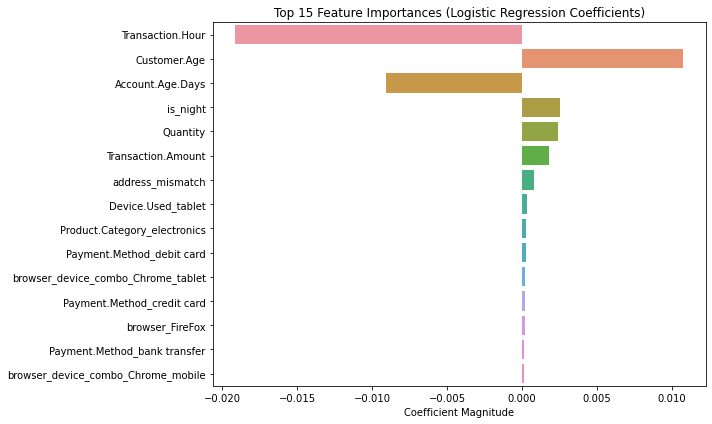

In [23]:
##logistic regression base model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load updated data
df = pd.read_csv(r"C:\Users\chefj\Downloads\INDENG142\processed_dataset.csv")

# Drop non-numeric columns
X = df.drop(columns=["Is.Fraudulent", "repetition_key"], errors='ignore')
X = X.select_dtypes(exclude=["object"])
y = df["Is.Fraudulent"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Retrain logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Feature importance plot
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values[:15], y=importance.index[:15])
plt.title("Top 15 Feature Importances (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()

## Decision Tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits


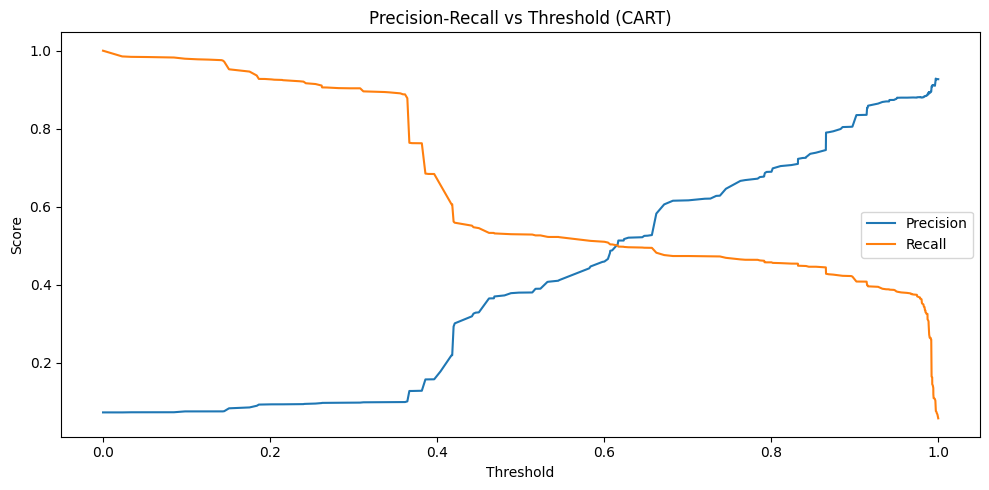

✅ Optimal threshold selected: 0.865
[[82535   984]
 [ 3603  2878]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     83519
           1       0.75      0.44      0.56      6481

    accuracy                           0.95     90000
   macro avg       0.85      0.72      0.76     90000
weighted avg       0.94      0.95      0.94     90000

ROC AUC Score: 0.7881449554863297


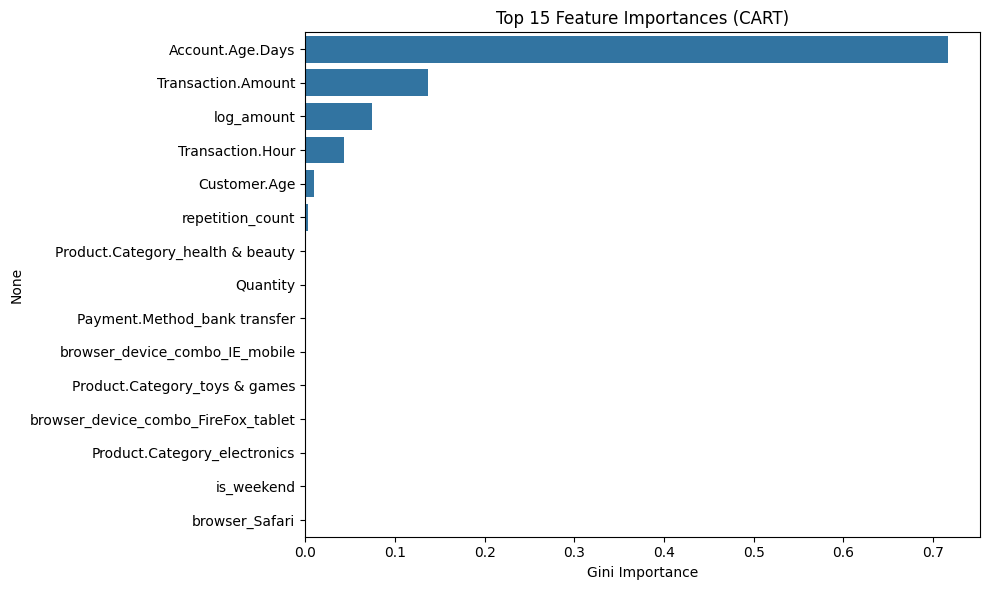

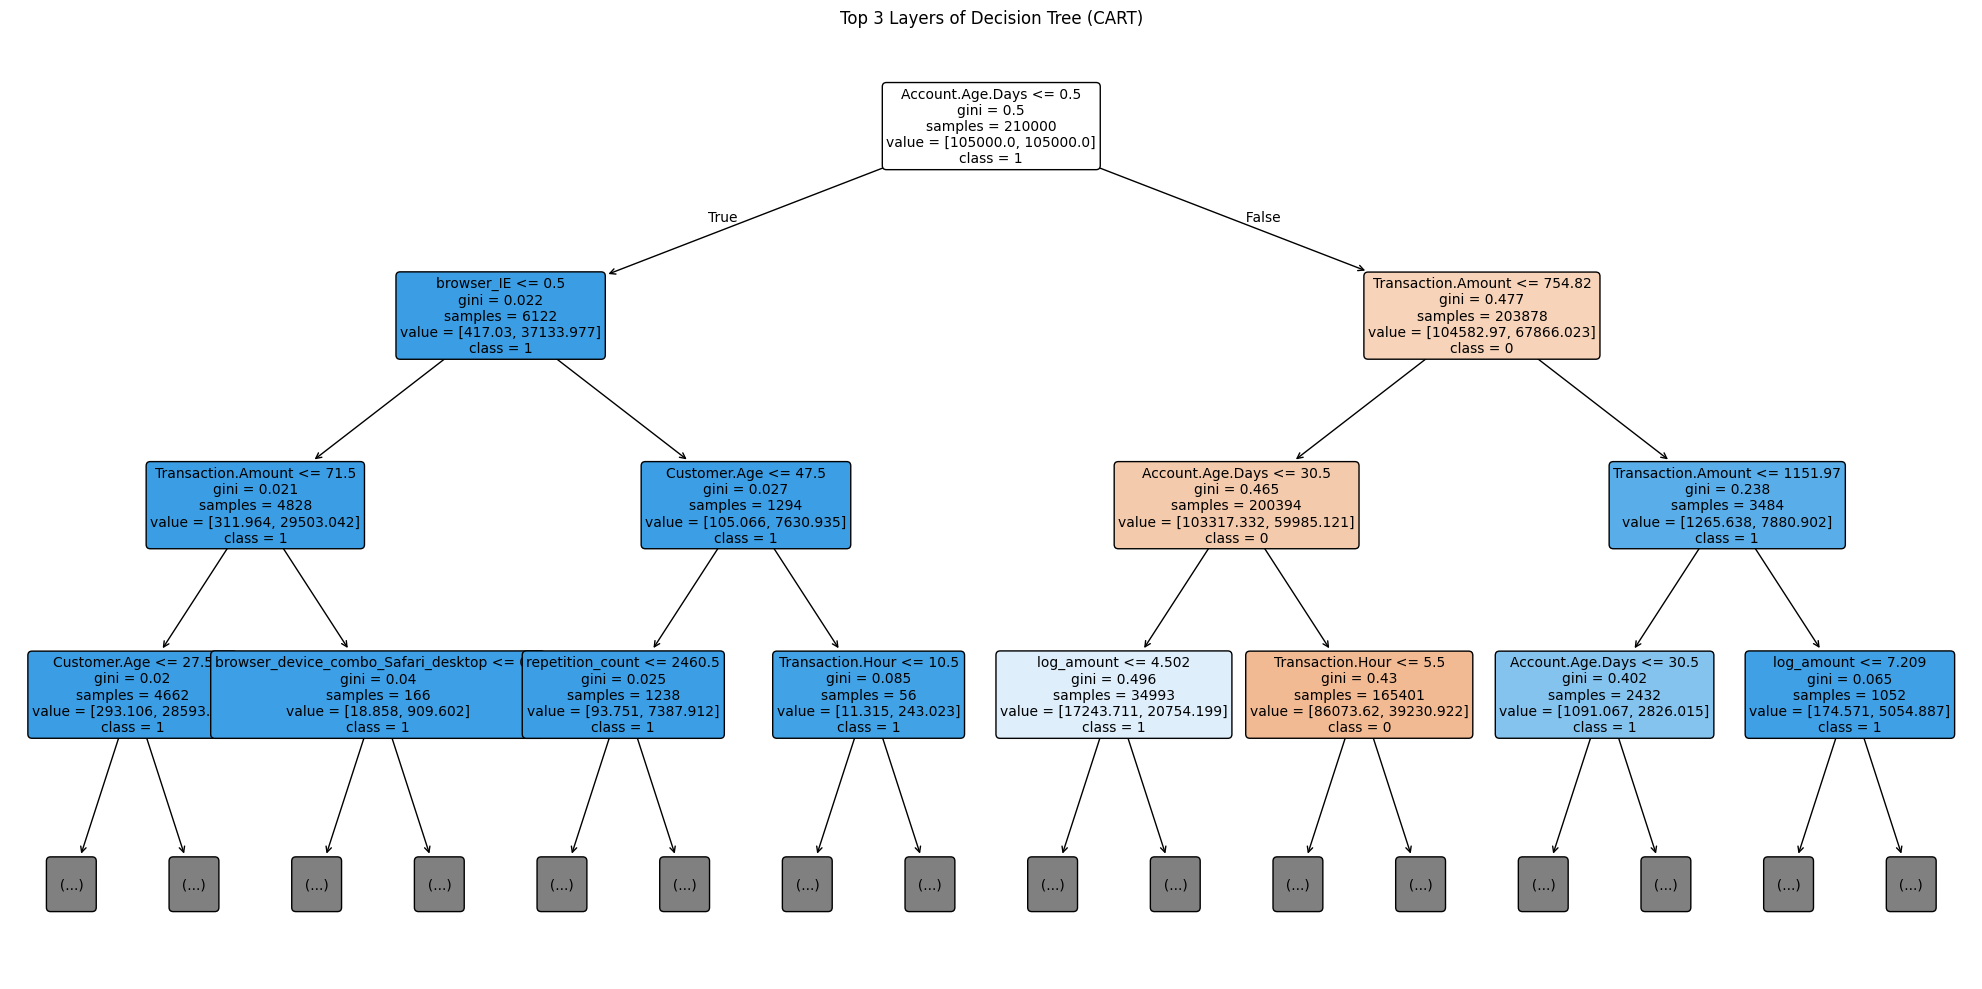

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    scoring='recall',
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
best_cart = search.best_estimator_

#Predict probabilities
y_prob_cart = best_cart.predict_proba(X_test)[:, 1]

# Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_cart)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (CART)")
plt.legend()
plt.tight_layout()
plt.show()

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"✅ Optimal threshold selected: {best_threshold:.3f}")

# Final prediction using best threshold
y_pred_cart = (y_prob_cart >= best_threshold).astype(int)

# Performance evaluation
print(confusion_matrix(y_test, y_pred_cart))
print(classification_report(y_test, y_pred_cart))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_cart))

# Ranking feature importances
cart_importance = pd.Series(best_cart.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=cart_importance.values[:15], y=cart_importance.index[:15])
plt.title("Top 15 Feature Importances (CART)")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(
    best_cart,
    feature_names=X.columns,
    class_names=[str(cls) for cls in best_cart.classes_],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  
)
plt.title("Top 3 Layers of Decision Tree (CART)")
plt.tight_layout()
plt.show()

In [34]:
n_nodes = best_cart.tree_.node_count
n_leaves = best_cart.get_n_leaves()
n_splits = n_nodes - n_leaves

print(f"Total nodes: {n_nodes}")
print(f"Leaf nodes: {n_leaves}")
print(f"✅ Number of splits: {n_splits}")

Total nodes: 833
Leaf nodes: 417
✅ Number of splits: 416


## Random Forest Model

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/envs/bto/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


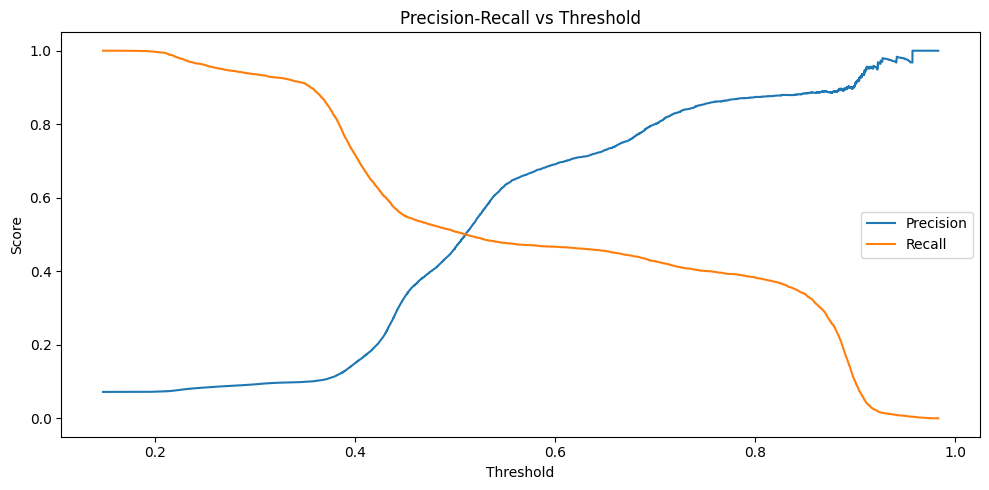

✅ Optimal threshold selected: 0.650
[[82427  1092]
 [ 3527  2954]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     83519
           1       0.73      0.46      0.56      6481

    accuracy                           0.95     90000
   macro avg       0.84      0.72      0.77     90000
weighted avg       0.94      0.95      0.94     90000

ROC AUC Score: 0.7967980731924182


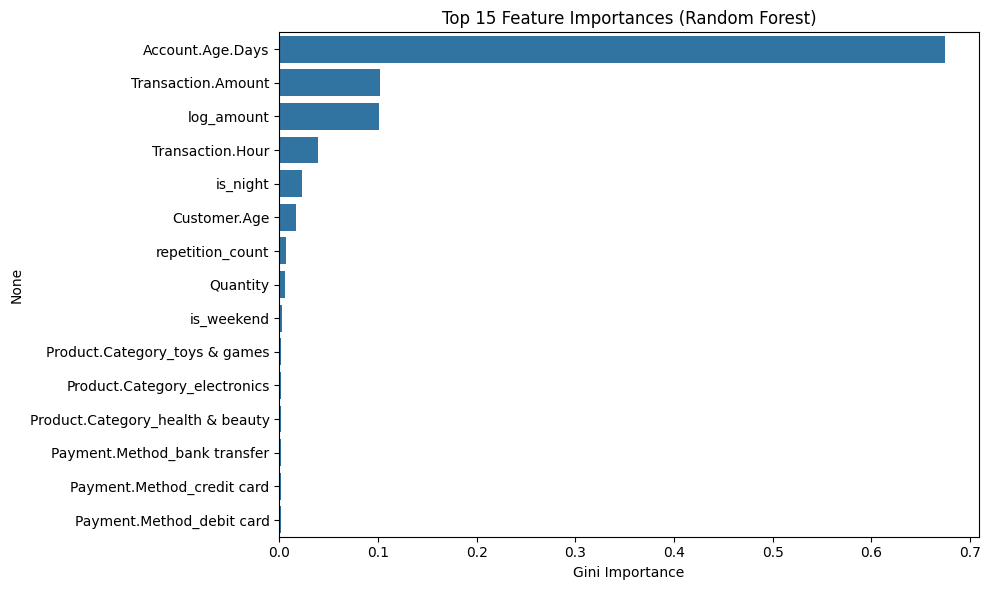

In [ ]:
##random forest baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    scoring='recall',
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

# Predict probabilities
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Tune threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()

# Choosing optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"✅ Optimal threshold selected: {best_threshold:.3f}")

#Final prediction using best threshold
y_pred_rf = (y_prob_rf >= best_threshold).astype(int)

# Performance Evaluation
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

#Ranking feature importances
rf_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance.values[:15], y=rf_importance.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()

## XGBoost Model

c:\Users\chefj\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[78618  4901]
 [ 3038  3443]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     83519
           1       0.41      0.53      0.46      6481

    accuracy                           0.91     90000
   macro avg       0.69      0.74      0.71     90000
weighted avg       0.92      0.91      0.92     90000

ROC AUC Score: 0.8007793611916587


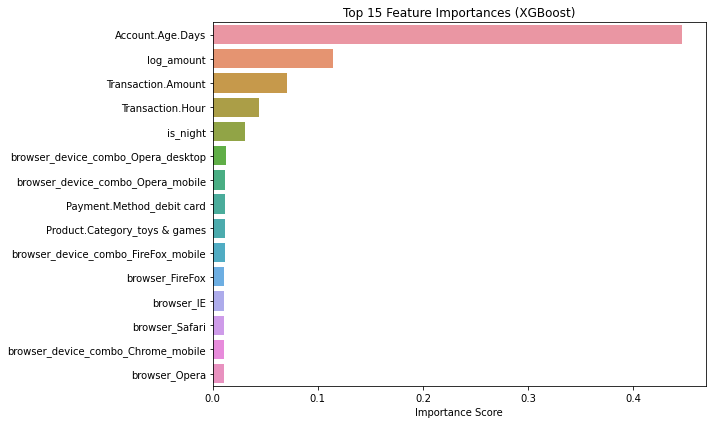

In [ ]:
##XGBoost implementation (gradient boosting)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load processed data
df = pd.read_csv(r"C:\Users\chefj\Downloads\INDENG142\processed_dataset.csv")

# Prepare features
X = df.drop(columns=["Is.Fraudulent"])
X = X.select_dtypes(exclude=["object"])
y = df["Is.Fraudulent"]

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # balance classes
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict + Evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))


# Feature importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importance = xgb_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importance.values[:15], y=xgb_importance.index[:15])
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## Fully Optimized Model


✅ Optimal threshold selected: 0.629


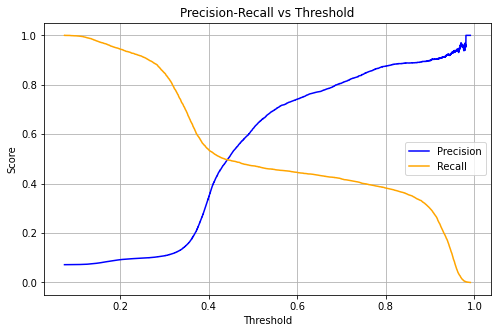

[[82639   880]
 [ 3636  2845]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     83519
           1       0.76      0.44      0.56      6481

    accuracy                           0.95     90000
   macro avg       0.86      0.71      0.77     90000
weighted avg       0.94      0.95      0.94     90000

ROC AUC Score: 0.7917410261441905


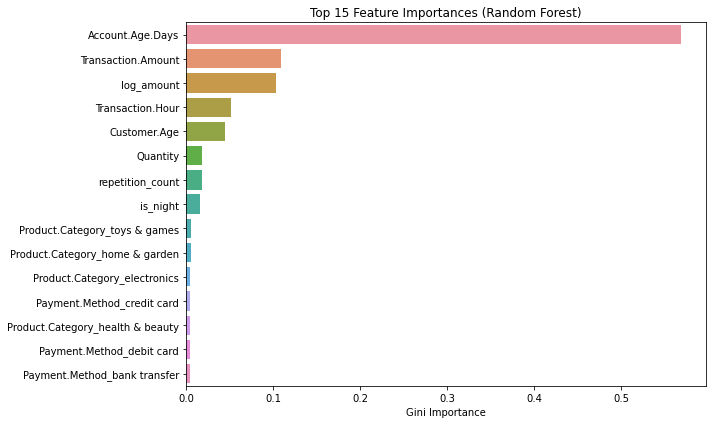

In [ ]:
##Fully optimized model - Random Forest with hyperparameters tuned + threshold selection optimized.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load processed dataset
df = pd.read_csv(r"C:\Users\chefj\Downloads\INDENG142\processed_dataset.csv")
X = df.drop(columns=["Is.Fraudulent"])
y = df["Is.Fraudulent"]

# Drop non-numeric columns (safety check)
X = X.select_dtypes(exclude=["object"])

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Step 1: Tune Random Forest (you already did this – now we use tuned params)
best_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': 42
}

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Step 2: Predict probabilities
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Step 3: Precision-Recall Curve to find best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\n✅ Optimal threshold selected: {optimal_threshold:.3f}")

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='orange')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Final predictions using optimal threshold
y_pred_rf_final = (y_prob_rf >= optimal_threshold).astype(int)

print(confusion_matrix(y_test, y_pred_rf_final))
print(classification_report(y_test, y_pred_rf_final))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

#Plotting feature importances

rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance.values[:15], y=rf_importance.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()
